In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk 
import string
import re
import codecs
import json
#%matplotlib inline
#pd.set_option('display.max_colwidth', 100)

import hdbscan
import nltk
import numpy as np
import pandas as pd
import random
import re
import spacy
import textacy
import csv
import sklearn

from gmplot import gmplot
from mapsplotlib import mapsplot as mplt
from nltk.corpus import twitter_samples
from nltk.tag import pos_tag_sents
from pymprog import *
from sklearn.cluster import DBSCAN
from sklearn.neighbors import DistanceMetric
from sklearn.feature_extraction.text import CountVectorizer

import pandas as pd

import datetime
from time import strptime

from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
from sklearn.cluster import KMeans
import clustering_models as cl
import timestamp_graphs as tg
import warnings
warnings.filterwarnings('ignore')

In [2]:
colnames=['tweets', 'created_at', 'id','rt','lang','location','coordinates','Event'] 
df_relevant = pd.read_csv('relevant_with_coordinates.csv', names=colnames, header=None)
print(df_relevant.shape[0])
df_relevant.head(1)

106017


,tweets,created_at,id,rt,lang,location,coordinates,Event
0,News: Chinese author Mo Yan wins Nobel http://...,Thu Oct 11 11:08:32 +0000 2012,256350567369175040,False,en,Eindhoven,"{""lat"": 51.47601928708412, ""lon"": 5.4647688255...",0


In [3]:
# json.loads(df_relevant["coordinates"][0])['lat']

In [4]:
colnames=['tweets', 'created_at', 'id','rt','lang','location','coordinates'] 
df_irrelevant = pd.read_csv('irrelevant_with_coordinates.csv', names=colnames, header=None)
df_irrelevant['Event'] = -1
print(df_irrelevant.shape[0])
df_irrelevant.head(1)

413986


,tweets,created_at,id,rt,lang,location,coordinates,Event
0,I love ms.sivney class (Sports &amp; Entertaim...,Wed Oct 31 16:48:39 +0000 2012,263683917889040400,False,en,Macedonia,"{'lat': 41.82038761113906, 'lon': 22.008566323...",-1


In [5]:
frames = [df_relevant,df_irrelevant]
df = pd.concat(frames)

## Remove tweets that are not in English

Index(['en', 'und', 'in', 'tl', 'es', 'ht', 'fr', 'et', 'pt', 'de', 'nl', 'ca',
       'ro', 'da', 'it', 'pl', 'cy', 'cs', 'sv', 'ja', 'no', 'tr', 'fi', 'hi',
       'lt', 'zh', 'hu', 'lv', 'ko', 'eu', 'sl', 'vi', 'is', 'ar', 'th', 'hy',
       'ru', 'my'],
      dtype='object')


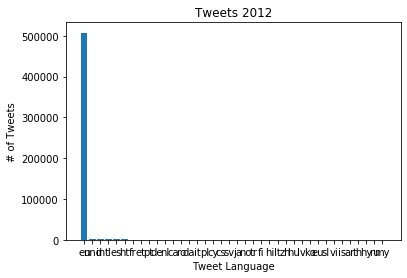

In [6]:
import matplotlib.pyplot as plt
# plots number of tweets in each language
counts = df['lang'].value_counts()
plt.bar(counts.index, counts, align='center', alpha=1)
plt.xlabel('Tweet Language')
plt.ylabel('# of Tweets')
plt.title('Tweets 2012')
print(counts.index)

In [7]:
print("Old df shape:",df.shape[0])
df = df.loc[df["lang"]=='en']
print("New df shape:",df.shape[0])

Old df shape: 520003
New df shape: 507519


# Flagging all potential eventful tweets

In [8]:
import timestamp_graphs as tg
df = df.reset_index(drop=True)
df = tg.createTimestamps(df)
list_date_ten = tg.getList(df,'Date_Ten_Minutes')
len(list_date_ten)

4033

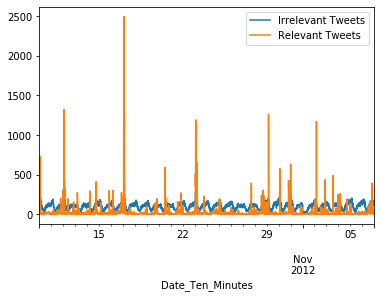

In [9]:
df_relevant = tg.createTimestamps(df_relevant)
df_irrelevant = tg.createTimestamps(df_irrelevant)
tg.monitorGraphPerTenMinutes(df_relevant,df_irrelevant)

In [10]:
list_date_minutes = tg.getList(df,'Datetime')
print(len(list_date_minutes))

39951


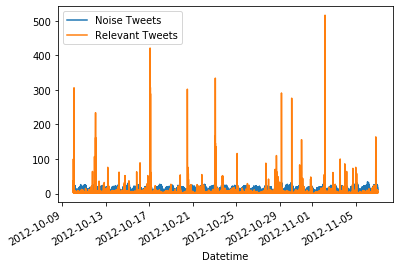

In [11]:
tg.monitorGraphPerMinute(df_relevant,df_irrelevant)

In [12]:
list_date_hour = tg.getList(df,'DateHour')
print(len(list_date_hour))

673


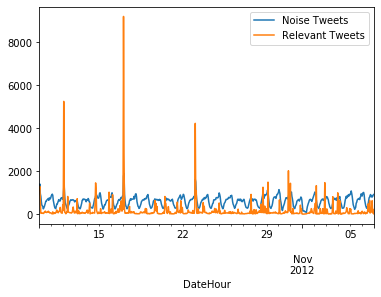

In [13]:
tg.monitorGraphPerHour(df_relevant,df_irrelevant)

In [14]:
df_relevant.shape[0]

106017

In [15]:
df_irrelevant.shape[0]

413986

<h3> Remove hashtags,mentions,retweets from the tweet and import them to a new column </h3>

In [16]:
import data_preprocessing_methods as dpm

In [17]:
temp = np.vectorize(dpm.remove_patterns)(df['tweets'],"@[\w]*","#[\w]*","RT")
df["text"] = np.array([text["input_text"] for text in temp])
df["hashtag"] = np.array([dpm.list_lower(text["hashtags"]) for text in temp])
df["user_mentions"] = np.array([text["user_mentions"] for text in temp]) 
df["RT"] = np.array([text["is_RT"] for text in temp])
df["URL"] = np.array([text["is_URL"] for text in temp])

<h3> Remove punctuation and Tokenization</h3>

In [18]:
df['Tweet_punct'] = df['text'].apply(lambda x: dpm.remove_punct(x))
df['Tweet_tokenized'] = df['Tweet_punct'].apply(lambda x: dpm.tokenization(x.lower()))

<h3>Remove stopwords</h3>

In [19]:
stopword = nltk.corpus.stopwords.words('english')
df['Tweet_nonstop'] = df['Tweet_tokenized'].apply(lambda x: dpm.remove_stopwords(x,stopword))

<h3> Stemming </h3

In [20]:
# Stemming is the process of breaking a word down into its root.
stemmer = SnowballStemmer('english')
stops = set(stopwords.words("english"))

df["Stem_sent"] = np.array([dpm.stemming_to_sent(temp,stemmer) for temp in df["Tweet_nonstop"]])
df["Stem_words"] = np.array([dpm.stemming_to_words(temp,stemmer) for temp in df["Tweet_nonstop"]])
df["No"] = np.array([i for i in range(0,df.shape[0])])

In [21]:
df["clean_data"] = np.array([dpm.new_clean_data(i,df) for i in range(df.shape[0])])

# Reverse Geocoding

In [22]:
%load_ext autotime


In [23]:
df["clean_data_coordinates"] = dpm.reverse_geocoding(df)

Loading formatted geocoded file...
100000
200000
300000
400000
500000
time: 2min 31s


# Creation of Clusters

### Time window metrics

In [27]:
df = df.sort_values(by=['Datetime'])

time: 1.85 s


In [24]:
import clustering_processing as cp

time: 123 ms


In [25]:
dataframe_time_window_0_6 = cp.create_clusters_time_window(df,2,0.6,1,0,True,'hierarchical',list_date_minutes)
# dataframe_time_window_0_6.to_csv(r'ClusterTimeWindow_0_6.csv', index = False)

time: 1min 36s


In [ ]:
dataframe_time_window_0_5 = cp.create_clusters_time_window(df,2,0.5,0,0,True,'dbscan',list_date_minutes)
# dataframe_time_window_0_5.to_csv(r'ClusterTimeWindow_0_5.csv', index = False)

### Hourly metrics

# Evaluation Metrics

In [ ]:
result1,map_df,cluster_spec_df = cp.create_clusters_hourly(df,2,0.5,1,0,False,'dbscan',list_date_hour)
result2,map_df2,cluster_spec_df2 = cp.create_clusters_hourly(df,2,0.5,1,0,True,'dbscan',list_date_hour)

# Presentation of Clusters

### Present clusters in time window of 30 seconds

 ### Present clusters for every hour

In [ ]:
dbscan_show = cp.create_clusters_show_time_window(df,2,0.4,0,0,True,'dbscan',list_date_minutes)

In [ ]:
cp.create_clusters_show_time_window(df,2,0.5,0,0,True,'kmeans',list_date_minutes)

Timestamp: 2012-10-10 00:05:00 - 2012-10-10 00:14:00
Size:  1
-1  

Timestamp: 2012-10-10 00:08:00 - 2012-10-10 00:17:00
Size:  1
-1  

Timestamp: 2012-10-10 00:10:00 - 2012-10-10 00:19:00
Size:  58
394  394  394  394  394  394  394  394  394  394  487  487  394  394  394  394  394  394  394  394  19  19  394  394  394  394  394  394  394  394  394  394  394  394  394  394  394  75  394  75  394  394  394  394  383  75  394  394  394  394  394  394  394  394  394  394  394  394  

Timestamp: 2012-10-10 00:10:00 - 2012-10-10 00:19:00
Size:  1
-1  

Timestamp: 2012-10-10 00:10:00 - 2012-10-10 00:19:00
Size:  157
-1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  386  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -